In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import os
import glob
from collections import Counter

# Define paths to label directories
base_path = '/content/drive/My Drive/Project/srip/labels/labels/'
native_labels_path = os.path.join(base_path, 'labels_native/*.txt')
hd_labels_path = os.path.join(base_path, 'labels_hd/*.txt')

# Get all label files
native_label_files = glob.glob(native_labels_path)
hd_label_files = glob.glob(hd_labels_path)
all_label_files = native_label_files + hd_label_files

print(f"Total number of label files found: {len(all_label_files)}")

# Initialize counters
total_instances = 0
labels_per_image = []

# Process each label file
for label_file in all_label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        num_labels = len(lines)  # Number of bounding boxes (solar panels) in this image
        labels_per_image.append(num_labels)
        total_instances += num_labels

# Compute statistics
print(f"Total number of solar panel instances: {total_instances}")

# Value counts of labels per image
label_counts = Counter(labels_per_image)
for num_labels, count in sorted(label_counts.items()):
    print(f"Images with {num_labels} labels: {count}")

Total number of label files found: 5094
Total number of solar panel instances: 59505
Mean area of solar panels: 0.0011 square meters
Standard deviation of areas: 0.0036 square meters


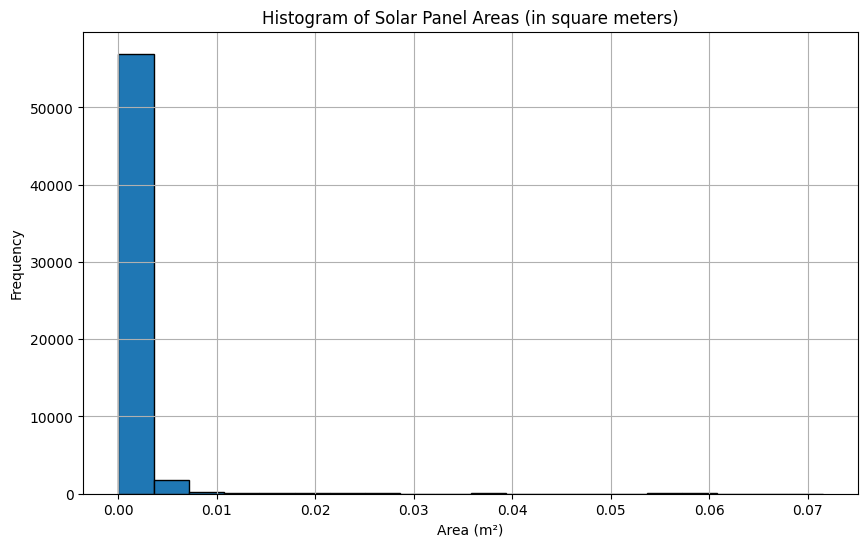

Observations from the histogram:
- Replace this with what you see, e.g., 'Most areas are between X and Y m², with a peak at Z m².'


In [ ]:
# Import libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Define paths to label directories
base_path = '/content/drive/My Drive/Project/srip/labels/labels/'
native_labels_path = os.path.join(base_path, 'labels_native/*.txt')
hd_labels_path = os.path.join(base_path, 'labels_hd/*.txt')

# Get all label files
all_label_files = glob.glob(native_labels_path) + glob.glob(hd_labels_path)
print(f"Total number of label files found: {len(all_label_files)}")

# Conversion factor: 31 cm = 0.31 meters for 416 pixels
pixel_to_meter = 0.31 / 416  # meters per pixel
image_size = 416  # Image width and height in pixels

# Store areas
areas = []

# Process each label file
for label_file in all_label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Parse YOLO format: class x_center y_center width height (normalized)
            parts = line.strip().split()
            if len(parts) < 5:
                continue  # Skip malformed lines
            width = float(parts[3]) * image_size  # Denormalize to pixels
            height = float(parts[4]) * image_size  # Denormalize to pixels

            # Convert to meters
            width_m = width * pixel_to_meter
            height_m = height * pixel_to_meter

            # Calculate area in square meters
            area = width_m * height_m
            areas.append(area)

# Convert to numpy array for statistics
areas = np.array(areas)

# Calculate statistics
mean_area = np.mean(areas)
std_area = np.std(areas)

print(f"Total number of solar panel instances: {len(areas)}")
print(f"Mean area of solar panels: {mean_area:.4f} square meters")
print(f"Standard deviation of areas: {std_area:.4f} square meters")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=20, edgecolor='black')
plt.title('Histogram of Solar Panel Areas (in square meters)')
plt.xlabel('Area (m²)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Observations (to be filled based on the plot)
print("Observations from the histogram:")
print("- Replace this with what you see, e.g., 'Most areas are between X and Y m², with a peak at Z m².'")

In [ ]:
# Install required libraries
!pip install shapely supervision

# Import libraries
from shapely.geometry import box
import numpy as np
import supervision as sv

# Function to convert YOLO format to corner coordinates
def yolo_to_corners(x_center, y_center, width, height, image_size=416):
    x_center *= image_size
    y_center *= image_size
    width *= image_size
    height *= image_size
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return x_min, y_min, x_max, y_max

# IoU function using Shapely
def compute_iou_shapely(box1, box2, image_size=416):
    # Box1 and Box2 are in YOLO format: [x_center, y_center, width, height]
    x1_min, y1_min, x1_max, y1_max = yolo_to_corners(*box1, image_size)
    x2_min, y2_min, x2_max, y2_max = yolo_to_corners(*box2, image_size)

    # Create Shapely boxes
    b1 = box(x1_min, y1_min, x1_max, y1_max)
    b2 = box(x2_min, y2_min, x2_max, y2_max)

    # Compute intersection and union
    intersection = b1.intersection(b2).area
    union = b1.area + b2.area - intersection

    # Compute IoU
    iou = intersection / union if union > 0 else 0
    return iou

# Test the function
box1 = [0.5, 0.5, 0.2, 0.2]  # Example box 1 (center at 50%, 20% width/height)
box2 = [0.55, 0.55, 0.2, 0.2]  # Example box 2 (slightly offset)

iou_shapely = compute_iou_shapely(box1, box2)
print(f"IoU using Shapely: {iou_shapely:.4f}")

# Compare with Supervision
# Supervision uses [x_min, y_min, x_max, y_max] format
def yolo_to_supervision(box, image_size=416):
    x_min, y_min, x_max, y_max = yolo_to_corners(*box, image_size)
    return np.array([[x_min, y_min, x_max, y_max]])

# Convert boxes to supervision format
detections1 = sv.Detections(xyxy=yolo_to_supervision(box1), confidence=np.array([1.0]), class_id=np.array([0]))
detections2 = sv.Detections(xyxy=yolo_to_supervision(box2), confidence=np.array([1.0]), class_id=np.array([0]))

# Compute IoU using Supervision
iou_supervision = sv.box_iou_batch(detections1.xyxy, detections2.xyxy)[0, 0]

print(f"IoU using Supervision: {iou_supervision:.4f}")

# Difference
print(f"Difference between Shapely and Supervision IoU: {abs(iou_shapely - iou_supervision):.6f}")

IoU using Shapely: 0.3913
IoU using Supervision: 0.3913
Difference between Shapely and Supervision IoU: 0.000000


In [ ]:
# Install required libraries (if not already installed)
!pip install shapely supervision numpy

# Import libraries
import numpy as np
from shapely.geometry import box

# Reuse IoU function from previous step
def yolo_to_corners(x_center, y_center, width, height, image_size=100):
    x_center *= image_size
    y_center *= image_size
    width *= image_size
    height *= image_size
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return x_min, y_min, x_max, y_max

def compute_iou_shapely(box1, box2, image_size=100):
    x1_min, y1_min, x1_max, y1_max = yolo_to_corners(*box1, image_size)
    x2_min, y2_min, x2_max, y2_max = yolo_to_corners(*box2, image_size)
    b1 = box(x1_min, y1_min, x1_max, y1_max)
    b2 = box(x2_min, y2_min, x2_max, y2_max)
    intersection = b1.intersection(b2).area
    union = b1.area + b2.area - intersection
    return intersection / union if union > 0 else 0

# AP Functions
def compute_ap_11_point(precisions, recalls):
    """Pascal VOC 11-point interpolation"""
    interp_precisions = []
    for recall_level in np.linspace(0, 1, 11):
        precisions_above = [p for (p, r) in zip(precisions, recalls) if r >= recall_level]
        interp_precisions.append(max(precisions_above) if precisions_above else 0)
    return np.mean(interp_precisions)

def compute_ap_101_point(precisions, recalls):
    """COCO 101-point interpolation"""
    interp_precisions = []
    for recall_level in np.linspace(0, 1, 101):
        precisions_above = [p for (p, r) in zip(precisions, recalls) if r >= recall_level]
        interp_precisions.append(max(precisions_above) if precisions_above else 0)
    return np.mean(interp_precisions)

def compute_ap_auc(precisions, recalls):
    """Area under Precision-Recall curve"""
    from sklearn.metrics import auc
    return auc(recalls, precisions)

# Compute precision and recall for AP
def compute_precision_recall(gt_boxes, pred_boxes, pred_confidences, iou_threshold=0.5):
    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)
    if num_gt == 0 or num_pred == 0:
        return [], []

    # Sort predictions by confidence
    sorted_indices = np.argsort(pred_confidences)[::-1]
    pred_boxes = [pred_boxes[i] for i in sorted_indices]
    pred_confidences = [pred_confidences[i] for i in sorted_indices]

    # Match predictions to ground truth
    ious = np.zeros((num_pred, num_gt))
    for i, pred in enumerate(pred_boxes):
        for j, gt in enumerate(gt_boxes):
            ious[i, j] = compute_iou_shapely(pred, gt)

    tp = np.zeros(num_pred)
    fp = np.zeros(num_pred)
    matched_gt = set()

    for i in range(num_pred):
        best_iou = np.max(ious[i])
        best_gt_idx = np.argmax(ious[i])
        if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
            tp[i] = 1
            matched_gt.add(best_gt_idx)
        else:
            fp[i] = 1

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    recalls = tp_cumsum / num_gt
    return precisions, recalls

# Generate random data
np.random.seed(42)
image_size = 100
box_size = 0.2  # 20x20 normalized
num_images = 10
all_ap_11, all_ap_101, all_ap_auc = [], [], []

for _ in range(num_images):
    # 10 ground truth boxes
    gt_boxes = [[np.random.uniform(0.1, 0.9), np.random.uniform(0.1, 0.9), box_size, box_size] for _ in range(10)]
    # 10 predicted boxes with random offsets
    pred_boxes = [[x + np.random.uniform(-0.05, 0.05), y + np.random.uniform(-0.05, 0.05), box_size, box_size]
                  for [x, y, _, _] in gt_boxes]
    pred_confidences = np.random.uniform(0.5, 1.0, 10)  # Random confidence scores

    # Compute precision and recall
    precisions, recalls = compute_precision_recall(gt_boxes, pred_boxes, pred_confidences, iou_threshold=0.5)

    # Compute AP for each method
    ap_11 = compute_ap_11_point(precisions, recalls)
    ap_101 = compute_ap_101_point(precisions, recalls)
    ap_auc = compute_ap_auc(precisions, recalls)

    all_ap_11.append(ap_11)
    all_ap_101.append(ap_101)
    all_ap_auc.append(ap_auc)

# Average AP50 across images
print(f"Average AP50 (11-point): {np.mean(all_ap_11):.4f}")
print(f"Average AP50 (101-point): {np.mean(all_ap_101):.4f}")
print(f"Average AP50 (AUC): {np.mean(all_ap_auc):.4f}")

Average AP50 (11-point): 0.7677
Average AP50 (101-point): 0.7629
Average AP50 (AUC): 0.6420


In [ ]:
# Install required libraries
!pip install ultralytics supervision matplotlib


# Import libraries
import os
import random
import shutil
from ultralytics import YOLO
import matplotlib.pyplot as plt
import supervision as sv

# Define paths
base_path = '/content/drive/My Drive/Project/srip/'
image_dir = os.path.join(base_path, 'images/image_chips_native')
label_dir = os.path.join(base_path, 'labels/labels/labels_native')
data_dir = '/content/data'  # Local working directory

# Create directories for train, val, test
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(data_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, split, 'labels'), exist_ok=True)

# Get all images and labels
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
label_files = [f.replace('.tif', '.txt') for f in image_files]
random.seed(42)
random.shuffle(image_files)

# Split: 80% train (72% train + 8% val), 20% test
train_size = int(0.8 * len(image_files))
test_size = len(image_files) - train_size
val_size = int(0.1 * train_size)  # 10% of train for validation
train_size = train_size - val_size

train_files = image_files[:train_size]
val_files = image_files[train_size:train_size + val_size]
test_files = image_files[train_size + val_size:]

# Copy files to local directories
def copy_files(file_list, split):
    for img in file_list:
        shutil.copy(os.path.join(image_dir, img), os.path.join(data_dir, split, 'images', img))
        label = img.replace('.tif', '.txt')
        if os.path.exists(os.path.join(label_dir, label)):
            shutil.copy(os.path.join(label_dir, label), os.path.join(data_dir, split, 'labels', label))

copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# Create data.yaml for YOLO
data_yaml = """
train: /content/data/train/images
val: /content/data/val/images
test: /content/data/test/images
nc: 1
names: ['solar_panel']
"""
with open('/content/data.yaml', 'w') as f:
    f.write(data_yaml)

# Load and train YOLOv8 model
model = YOLO('yolov8n.pt')  # Nano model for speed



100%|██████████| 6.25M/6.25M [00:00<00:00, 341MB/s]


Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

100%|██████████| 755k/755k [00:00<00:00, 100MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 199MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 1831 images, 7 backgrounds, 157 corrupt: 100%|██████████| 1838/1838 [00:01<00:00, 1276.57it/s]

train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_1398_y0_10006_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_1483_y0_10330_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels a

train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 201 images, 3 backgrounds, 25 corrupt: 100%|██████████| 204/204 [00:00<00:00, 737.87it/s] 

val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_3017_y0_4656_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_338_y0_7199_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_7511_y0_9647_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_8158_y0_9952_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_8232_y0_7817_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNIN

val: New cache created: /content/data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.19G      1.908      1.993      1.355         31        416: 100%|██████████| 106/106 [00:22<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        179       2072      0.569      0.459      0.484      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.42G      1.598      1.237      1.173         12        416: 100%|██████████| 106/106 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all        179       2072       0.77      0.582      0.683       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.42G       1.57      1.149      1.159          5        416: 100%|██████████| 106/106 [00:21<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all        179       2072      0.776      0.657      0.747      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.32G      1.485      1.058      1.121         22        416: 100%|██████████| 106/106 [00:19<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


                   all        179       2072      0.778      0.672      0.752      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.47G      1.433      1.025      1.109          6        416: 100%|██████████| 106/106 [00:21<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        179       2072      0.813      0.714       0.82      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.36G      1.411     0.9789      1.094         14        416: 100%|██████████| 106/106 [00:19<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all        179       2072      0.763      0.649       0.73      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.29G      1.369     0.9382      1.079         25        416: 100%|██████████| 106/106 [00:21<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all        179       2072      0.756      0.749      0.803      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.27G      1.356       0.92      1.071          5        416: 100%|██████████| 106/106 [00:19<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


                   all        179       2072      0.831      0.741      0.832       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.35G      1.332     0.9136      1.064         57        416: 100%|██████████| 106/106 [00:20<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]

                   all        179       2072      0.795      0.786      0.847      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.17G      1.329     0.8856      1.057          7        416: 100%|██████████| 106/106 [00:19<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all        179       2072      0.803      0.777      0.842      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.31G      1.279     0.8441      1.038          6        416: 100%|██████████| 106/106 [00:20<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all        179       2072      0.851      0.792      0.869      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.37G      1.281     0.8543      1.046         96        416: 100%|██████████| 106/106 [00:19<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        179       2072      0.852      0.752      0.854      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.23G      1.276      0.841      1.033          6        416: 100%|██████████| 106/106 [00:20<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all        179       2072      0.818       0.78      0.862      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.23G       1.28     0.8384       1.03          2        416: 100%|██████████| 106/106 [00:19<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        179       2072      0.856      0.777      0.867       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.32G      1.241     0.8051       1.02         56        416: 100%|██████████| 106/106 [00:19<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.60it/s]

                   all        179       2072      0.862      0.818      0.889      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.33G      1.199     0.7706      1.015          9        416: 100%|██████████| 106/106 [00:19<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        179       2072      0.883      0.813      0.895      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.37G      1.199      0.755      1.005          8        416: 100%|██████████| 106/106 [00:19<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all        179       2072      0.869      0.818      0.899      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.24G      1.207     0.7656      1.006         22        416: 100%|██████████| 106/106 [00:21<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        179       2072      0.851      0.821      0.885      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.28G      1.191     0.7609       1.01         10        416: 100%|██████████| 106/106 [00:19<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]

                   all        179       2072      0.889      0.799      0.893      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.2G      1.184     0.7504          1          4        416: 100%|██████████| 106/106 [00:21<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all        179       2072      0.864      0.821      0.893      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.35G      1.183     0.7513      1.003          6        416: 100%|██████████| 106/106 [00:20<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

                   all        179       2072      0.887       0.82      0.904      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.36G      1.165     0.7282     0.9984         21        416: 100%|██████████| 106/106 [00:21<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]

                   all        179       2072      0.884       0.84      0.911      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.32G      1.156     0.7261     0.9934          2        416: 100%|██████████| 106/106 [00:19<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

                   all        179       2072      0.883      0.843       0.91      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.57G      1.134     0.7084     0.9845         17        416: 100%|██████████| 106/106 [00:20<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]

                   all        179       2072      0.879      0.853      0.911      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.38G      1.137     0.7154     0.9862          6        416: 100%|██████████| 106/106 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

                   all        179       2072      0.871      0.824      0.909      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.13G      1.112     0.6903     0.9786          9        416: 100%|██████████| 106/106 [00:19<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

                   all        179       2072      0.916      0.818      0.916      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.18G      1.102     0.6911     0.9742         65        416: 100%|██████████| 106/106 [00:20<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

                   all        179       2072      0.903      0.846       0.92      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       1.2G      1.109     0.6809     0.9794         15        416: 100%|██████████| 106/106 [00:19<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]

                   all        179       2072      0.898      0.825      0.913      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.17G        1.1     0.6702     0.9734          5        416: 100%|██████████| 106/106 [00:20<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

                   all        179       2072      0.909      0.849      0.926      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.22G      1.116     0.6877     0.9801          5        416: 100%|██████████| 106/106 [00:19<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]

                   all        179       2072      0.898      0.864       0.93      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.12G      1.077     0.6682     0.9628          4        416: 100%|██████████| 106/106 [00:21<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        179       2072      0.903      0.858      0.928      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.46G      1.068     0.6561     0.9676         20        416: 100%|██████████| 106/106 [00:19<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all        179       2072      0.894      0.855      0.925       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.49G      1.054     0.6426     0.9539         25        416: 100%|██████████| 106/106 [00:20<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]

                   all        179       2072      0.899      0.872      0.927      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.42G      1.042     0.6367      0.953          7        416: 100%|██████████| 106/106 [00:19<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]

                   all        179       2072      0.903      0.854      0.925      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.18G      1.053     0.6423     0.9534         20        416: 100%|██████████| 106/106 [00:21<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]

                   all        179       2072       0.92      0.847       0.93      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.26G      1.037     0.6296     0.9531         32        416: 100%|██████████| 106/106 [00:19<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.62it/s]

                   all        179       2072      0.903      0.877      0.937      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.37G       1.03     0.6249     0.9481          8        416: 100%|██████████| 106/106 [00:20<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

                   all        179       2072      0.912      0.875      0.937      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.35G      1.042     0.6356     0.9518         15        416: 100%|██████████| 106/106 [00:19<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        179       2072      0.909      0.869      0.932      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.22G      1.032     0.6222     0.9472          6        416: 100%|██████████| 106/106 [00:20<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]

                   all        179       2072      0.909      0.876      0.936      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.16G     0.9963     0.6152     0.9438         37        416: 100%|██████████| 106/106 [00:19<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

                   all        179       2072      0.916      0.874      0.938      0.716


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.17G       0.96     0.5948     0.9313         41        416: 100%|██████████| 106/106 [00:20<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]

                   all        179       2072      0.918      0.866      0.936      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.18G     0.9449      0.563     0.9236         45        416: 100%|██████████| 106/106 [00:18<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


                   all        179       2072      0.924      0.881       0.94      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.02G      0.928     0.5543     0.9212          3        416: 100%|██████████| 106/106 [00:18<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]

                   all        179       2072      0.922      0.878       0.94      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.38G     0.9161     0.5639     0.9157          1        416: 100%|██████████| 106/106 [00:18<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        179       2072      0.926      0.882      0.944       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.25G     0.9285     0.5592     0.9184          2        416: 100%|██████████| 106/106 [00:19<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]

                   all        179       2072      0.923      0.887      0.944      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.01G      0.896     0.5416     0.9125          1        416: 100%|██████████| 106/106 [00:18<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all        179       2072      0.931      0.882      0.944      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.25G     0.9044     0.5605     0.9109          2        416: 100%|██████████| 106/106 [00:19<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]

                   all        179       2072      0.932      0.883      0.947      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.28G     0.8825      0.529     0.9094         14        416: 100%|██████████| 106/106 [00:18<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.60it/s]

                   all        179       2072      0.934      0.885      0.948      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       1.1G     0.8694     0.5226     0.9007          1        416: 100%|██████████| 106/106 [00:19<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all        179       2072      0.928      0.892      0.948      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.13G     0.8764     0.5281     0.9048          1        416: 100%|██████████| 106/106 [00:18<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]

                   all        179       2072       0.93      0.891       0.95      0.749



50 epochs completed in 0.307 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


                   all        179       2072       0.93      0.891       0.95      0.749
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train


AttributeError: 'DetMetrics' object has no attribute 'history'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

In [ ]:
results = model.train(data='/content/data.yaml', epochs=10, imgsz=416, patience=10, batch=32)

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=10, time=None, patience=10, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222224, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/data/train/labels.cache... 1831 images, 7 backgrounds, 157 corrupt: 100%|██████████| 1838/1838 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_1398_y0_10006_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/data/train/images/solarpanels_native_1__x0_1483_y0_10330_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels a


val: Scanning /content/data/val/labels.cache... 201 images, 3 backgrounds, 25 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]


val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_3017_y0_4656_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_338_y0_7199_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_7511_y0_9647_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_8158_y0_9952_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/images/solarpanels_native_1__x0_8232_y0_7817_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNIN

       1/10      2.17G     0.7454     0.4548     0.8746        213        416: 100%|██████████| 53/53 [00:16<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all        179       2072      0.921      0.893      0.946      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       2.3G     0.8409     0.5082     0.8977        175        416: 100%|██████████| 53/53 [00:15<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        179       2072      0.916        0.9      0.941      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.32G     0.8537     0.5247     0.9059        190        416: 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all        179       2072      0.909      0.897       0.94      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       2.3G     0.9114     0.5487     0.9213        150        416: 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all        179       2072      0.907      0.904      0.942      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.16G     0.8747     0.5274     0.9069        195        416: 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        179       2072      0.907      0.902      0.944      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.25G     0.8522     0.5115     0.9034        149        416: 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all        179       2072      0.908      0.903      0.942      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.29G     0.8136     0.4936     0.8939        209        416: 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all        179       2072      0.934      0.895      0.949       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.12G     0.7848     0.4762     0.8815        166        416: 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all        179       2072      0.933      0.908      0.956      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.31G      0.773     0.4666     0.8785        122        416: 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all        179       2072      0.934      0.908      0.959      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.25G     0.7465     0.4531     0.8753        126        416: 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all        179       2072      0.931      0.918      0.958      0.791



10 epochs completed in 0.048 hours.
Optimizer stripped from runs/detect/train222224/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train222224/weights/best.pt, 6.2MB

Validating runs/detect/train222224/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


                   all        179       2072      0.931      0.918      0.958      0.791
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train222224


In [ ]:

# Mount Google Drive (already done)
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import os
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Path to results CSV
results_csv = 'runs/detect/train222224/results.csv'  # Adjust if run folder differs

# Check if file exists and print column names
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print("Columns in results.csv:")
    print(df.columns.tolist())  # Show all column names

    # Hypothesize validation box loss column (common options)
    possible_columns = ['val/box_loss', 'metrics/mAP50(B)', 'val/cls_loss', 'val/dfl_loss']
    val_loss_col = None
    for col in possible_columns:
        if col in df.columns:
            val_loss_col = col
            break

    if val_loss_col:
        print(f"Using column '{val_loss_col}' for validation loss.")
        plt.plot(df[val_loss_col].dropna(), label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss Convergence')
        plt.legend()
        plt.grid(True)
        plt.show()
        print("Validation loss convergence plot displayed.")
    else:
        print("No suitable validation loss column found. Available columns:")
        print(df.columns.tolist())
else:
    print(f"Results CSV not found at {results_csv}. Check the training run directory.")

# Rest of the code (prediction and visualization) remains unchanged
model = YOLO('runs/detect/train222224/weights/best.pt')
test_files = os.listdir(os.path.join('/content/data', 'test/images'))
test_images = [os.path.join('/content/data', 'test/images', f) for f in test_files[:4]]
predictions = model.predict(test_images)

for i, (img_path, pred) in enumerate(zip(test_images, predictions)):
    img = plt.imread(img_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)

    label_path = img_path.replace('images', 'labels').replace('.tif', '.txt')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            gt_boxes = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]
        for box in gt_boxes:
            x_c, y_c, w, h = box
            x_min = (x_c - w/2) * 416
            y_min = (y_c - h/2) * 416
            w *= 416
            h *= 416
            rect = plt.Rectangle((x_min, y_min), w, h, edgecolor='green', facecolor='none', label='Ground Truth' if i == 0 else "")
            plt.gca().add_patch(rect)

    for box in pred.boxes.xywh:
        x_c, y_c, w, h = box.tolist()
        x_min = x_c - w/2
        y_min = y_c - h/2
        rect = plt.Rectangle((x_min, y_min), w, h, edgecolor='red', facecolor='none', label='Predicted' if i == 0 else "")
        plt.gca().add_patch(rect)

    plt.title(f"Sample {i+1}")
    if i == 0:
        plt.legend()
    plt.axis('off')
    plt.show()

print("Visualizations completed.")

Output hidden; open in https://colab.research.google.com to view.